# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


/content/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", depth_confidence=-1, width_confidence=-1 ).eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

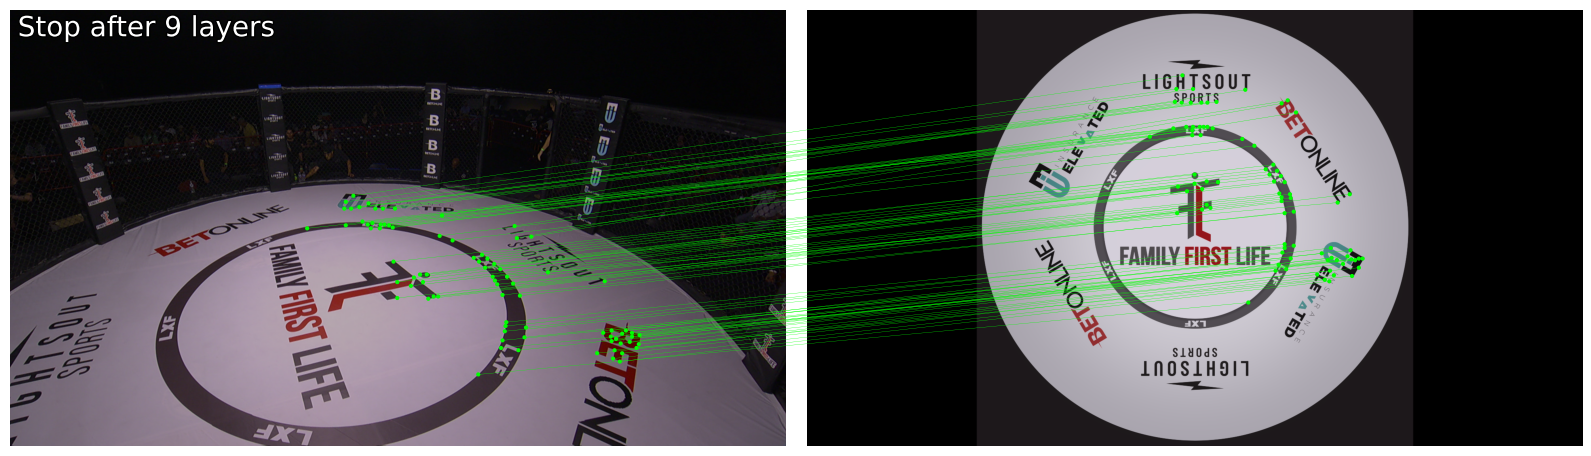

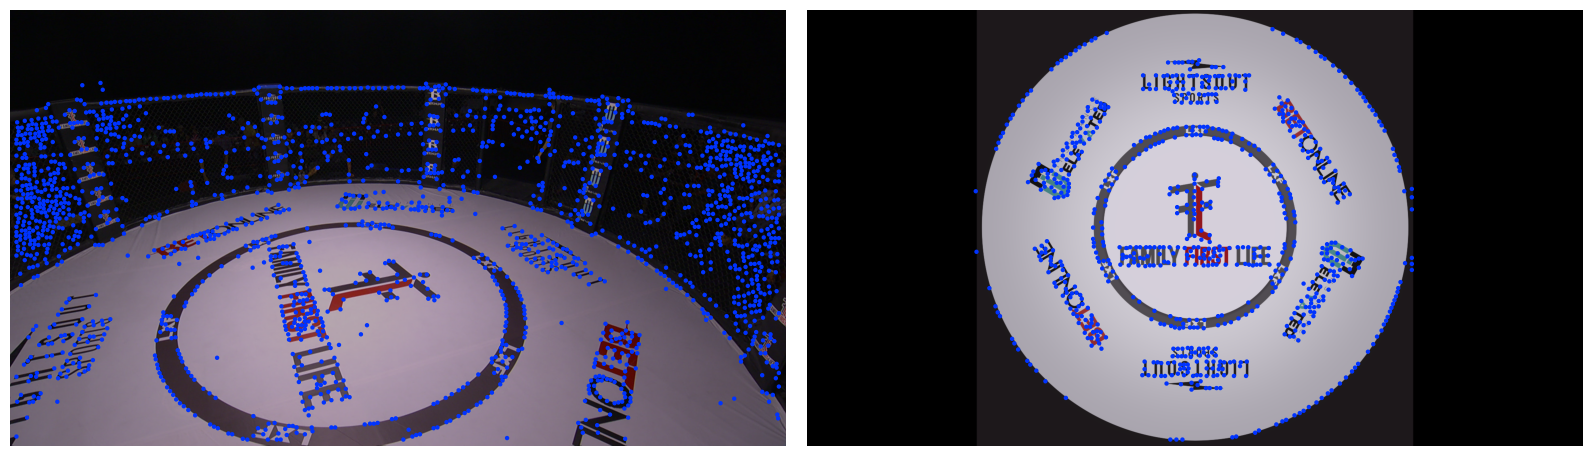

In [35]:
image0 = load_image("/content/jib_00058.png")
image1 = load_image("/content/Canvas_like_on_air_2.1.1.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))

# matches01 = matcher({"image0": feats0, "image1": feats1})
# feats0, feats1, matches01 = [
#     rbd(x) for x in [feats0, feats1, matches01]
# ]  # remove batch dimension

# kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
# m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

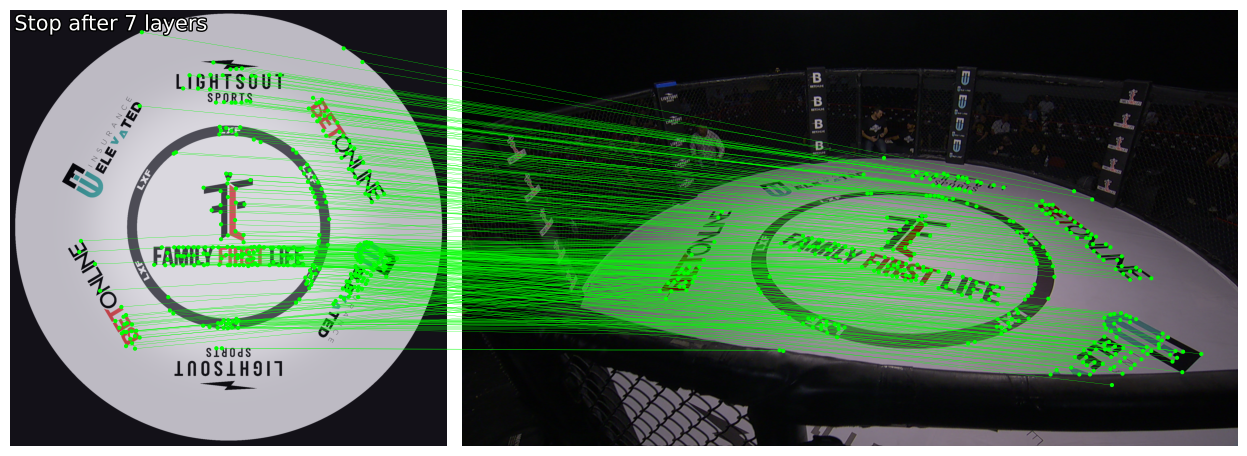

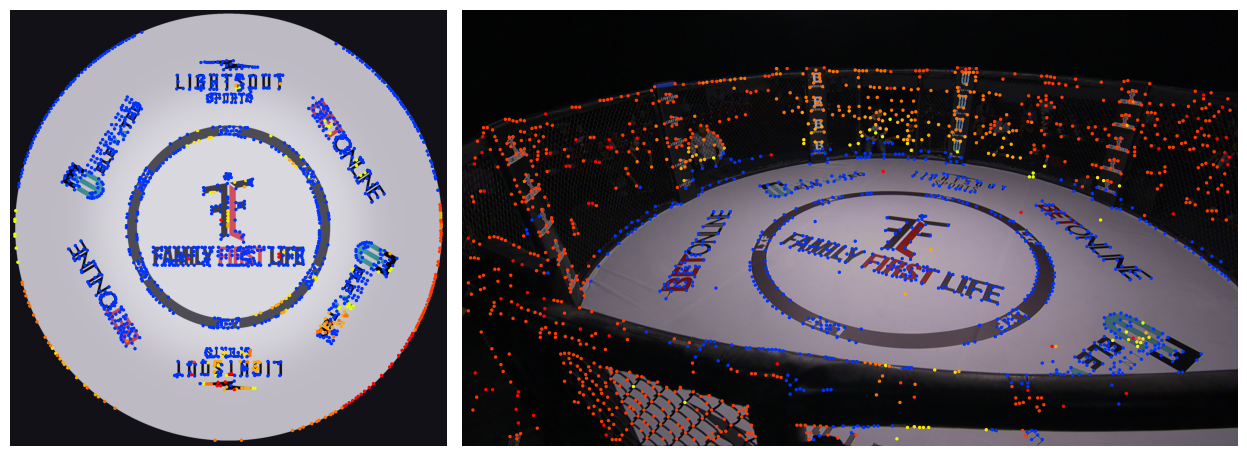

In [10]:
image0 = load_image("/content/canvas_1920_back_bgr.png")
image1 = load_image("/content/jib_00171.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [27]:
m_kpts0.shape

torch.Size([333, 2])

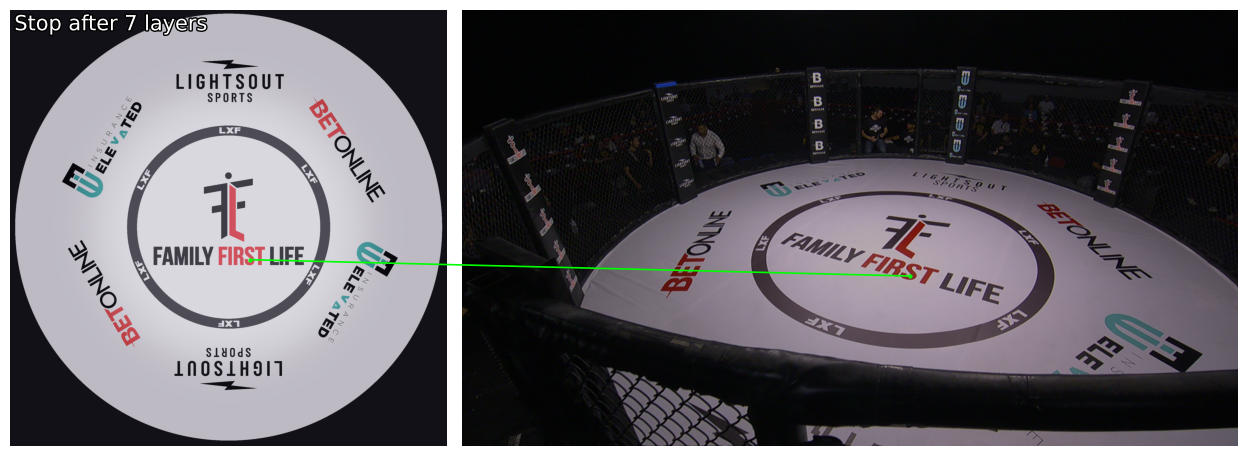

In [31]:
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0[200:201], m_kpts1[200:201], color="lime", lw=1.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [29]:
# prompt: /content/canvas_1920_back.png convert to bgr and save

import cv2

# Load the image
img = cv2.imread('/content/canvas_1920_back.png')
print(img.shape)

# Convert the image to BGR format
img_bgr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Save the BGR image
cv2.imwrite('/content/canvas_1920_back_bgr.png', img_bgr)

(1920, 1920, 3)


True

In [32]:
# prompt: need read image from /content/canvas_1920_back_bgr.png and rotate each 15 degree and save in /content/rotated

import cv2
import os

# Load the image
img = cv2.imread('/content/canvas_1920_back_bgr.png')

# Create the output directory if it doesn't exist
os.makedirs('/content/rotated', exist_ok=True)

# Rotate the image in 15-degree increments and save
for angle in range(0, 360, 15):
    # Rotate the image
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_img = cv2.warpAffine(img, M, (cols, rows))

    # Save the rotated image
    filename = f'/content/rotated/rotated_{angle}.png'
    cv2.imwrite(filename, rotated_img)